In [1]:
from sentiment import utils


DATASET_DIR = './goemotions_data/'
classes = utils.load_classes(DATASET_DIR)
classes.remove('neutral')
classes

['admiration',
 'amusement',
 'anger',
 'annoyance',
 'approval',
 'caring',
 'confusion',
 'curiosity',
 'desire',
 'disappointment',
 'disapproval',
 'disgust',
 'embarrassment',
 'excitement',
 'fear',
 'gratitude',
 'grief',
 'joy',
 'love',
 'nervousness',
 'optimism',
 'pride',
 'realization',
 'relief',
 'remorse',
 'sadness',
 'surprise']

In [2]:
%%time
train_df, val_df, test_df = utils.make_dataframes(DATASET_DIR,
                                                  fraction=0.85,
                                                  random=1682284394,
                                                  split_by_class=True,
                                                  drop_neutral=True,
                                                  test_only_singles=True,
                                                  oversample_low=True,
                                                  low_threshold=500)

Random seed: 1682284394
CPU times: total: 922 ms
Wall time: 954 ms


D:\sentiment-analysis\sentiment\utils.py:116: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  class_mask = (df['labels'].str.contains(f'(^|,){label}(,|$)',


D:\sentiment-analysis\sentiment\utils.py:568: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(classes, rotation=45, ha='right')


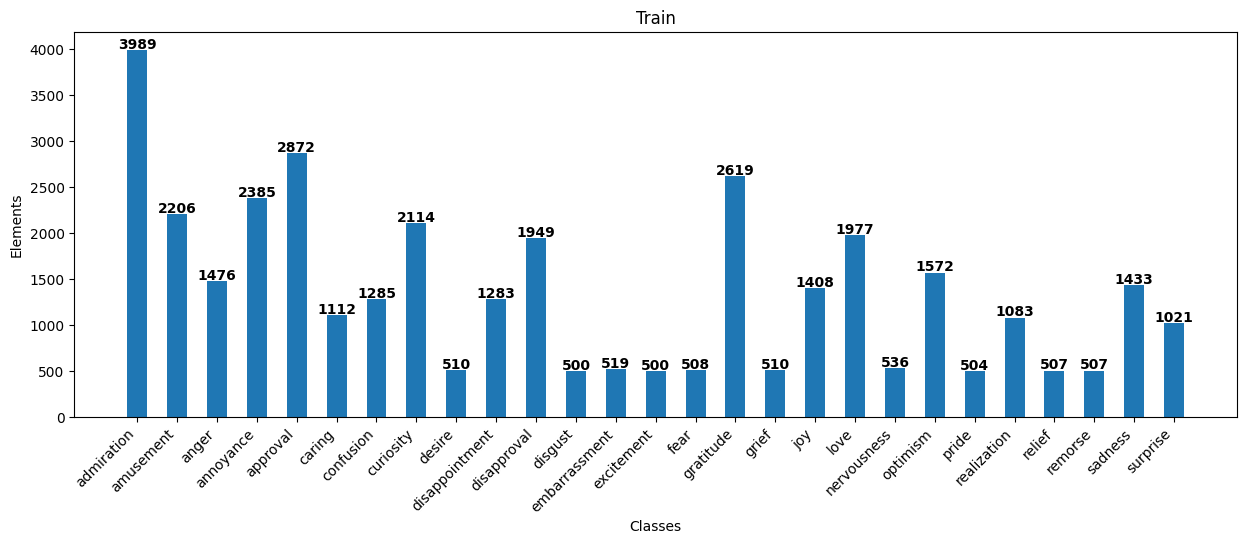

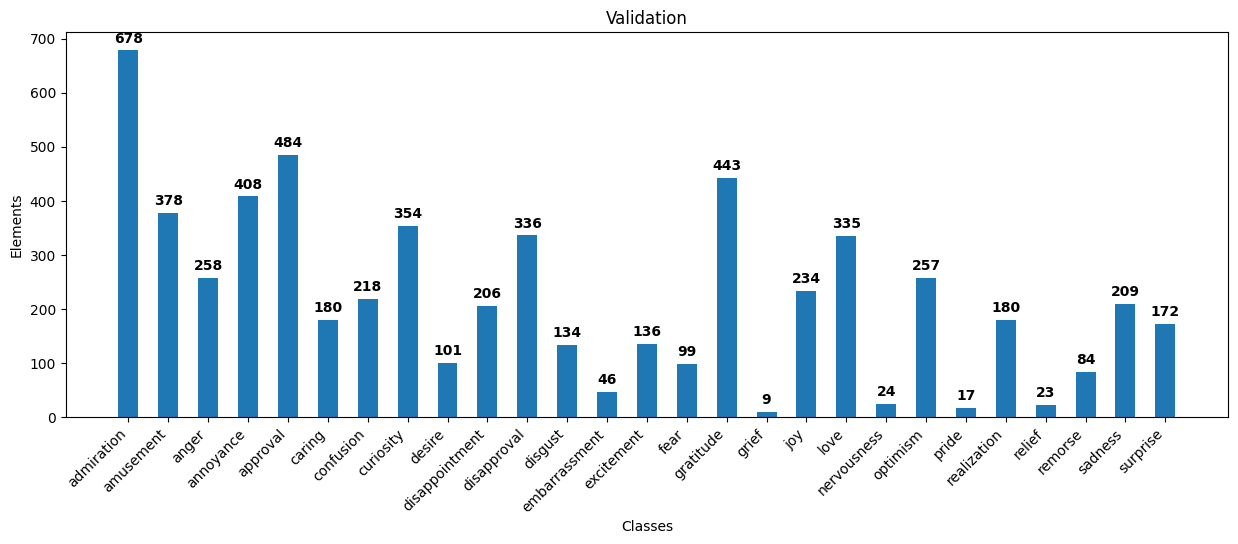

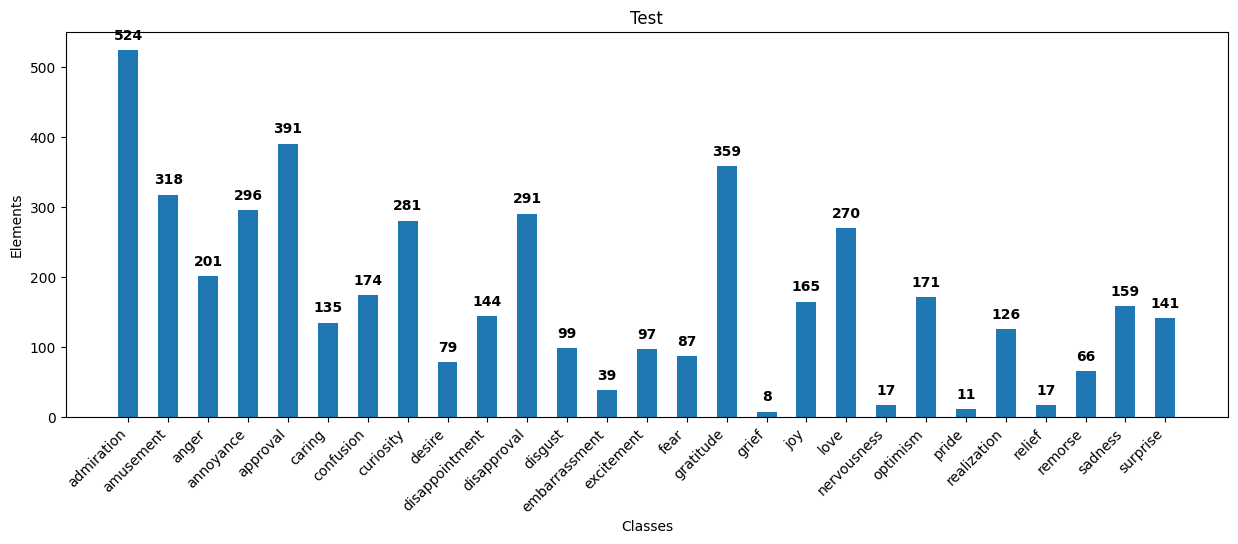

In [3]:
from tensorflow.data import AUTOTUNE

BATCH_SIZE = 64


dataframes = {'Train': train_df, 'Validation': val_df, 'Test': test_df}
for title, df in dataframes.items():
    utils.plot_class_distr(df, classes, title)
train_ds = utils.make_ts_ds(train_df, classes, BATCH_SIZE, AUTOTUNE)
val_ds = utils.make_ts_ds(val_df, classes, BATCH_SIZE, AUTOTUNE)
test_ds = utils.make_ts_ds(test_df, classes, BATCH_SIZE, AUTOTUNE)

In [4]:
from sentiment import bert_model

BERT_MODEL = 'small_bert/bert_en_uncased_L-2_H-128_A-2'


model = bert_model.BertSentimentModel(BERT_MODEL, classes=classes)

In [5]:
from official.nlp import optimization  # to create AdamW optimizer
import tensorflow as tf
from tensorflow.keras.losses import BinaryCrossentropy


THRESHOLD = 0.5
EPOCHS = 10
INIT_LR = 3e-4


steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * EPOCHS
num_warmup_steps = int(0.1*num_train_steps)
optimizer = optimization.create_optimizer(init_lr=INIT_LR,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')
metrics = utils.create_metrics(classes, THRESHOLD)
loss = BinaryCrossentropy()
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [6]:
from tensorflow.keras.callbacks import EarlyStopping


history = model.fit(x=train_ds, validation_data=val_ds, epochs=EPOCHS,
                    callbacks=[EarlyStopping(monitor='val_loss', patience=2)])

Epoch 1/10
463/463 [==============================] - 545s 1s/step - loss: 0.3073 - precision@0.5/admiration: 0.1582 - recall@0.5/admiration: 0.1040 - precision@0.5/amusement: 0.0671 - recall@0.5/amusement: 0.0920 - precision@0.5/anger: 0.0539 - recall@0.5/anger: 0.1484 - precision@0.5/annoyance: 0.0827 - recall@0.5/annoyance: 0.1375 - precision@0.5/approval: 0.0955 - recall@0.5/approval: 0.0930 - precision@0.5/caring: 0.0424 - recall@0.5/caring: 0.0513 - precision@0.5/confusion: 0.0417 - recall@0.5/confusion: 0.1673 - precision@0.5/curiosity: 0.0726 - recall@0.5/curiosity: 0.1310 - precision@0.5/desire: 0.0207 - recall@0.5/desire: 0.0745 - precision@0.5/disappointment: 0.0282 - recall@0.5/disappointment: 0.0405 - precision@0.5/disapproval: 0.0703 - recall@0.5/disapproval: 0.0549 - precision@0.5/disgust: 0.0174 - recall@0.5/disgust: 0.1300 - precision@0.5/embarrassment: 0.0110 - recall@0.5/embarrassment: 0.0443 - precision@0.5/excitement: 0.0196 - recall@0.5/excitement: 0.1580 - precis

In [7]:
eval_metrics = model.evaluate(x=test_ds, return_dict=True)
utils.print_metrics(eval_metrics)

73/73 [==============================] - 21s 283ms/step - loss: 0.0867 - precision@0.5/admiration: 0.7097 - recall@0.5/admiration: 0.7137 - precision@0.5/amusement: 0.7803 - recall@0.5/amusement: 0.8491 - precision@0.5/anger: 0.5118 - recall@0.5/anger: 0.4328 - precision@0.5/annoyance: 0.3333 - recall@0.5/annoyance: 0.2399 - precision@0.5/approval: 0.4838 - recall@0.5/approval: 0.3811 - precision@0.5/caring: 0.5536 - recall@0.5/caring: 0.4593 - precision@0.5/confusion: 0.4462 - recall@0.5/confusion: 0.1667 - precision@0.5/curiosity: 0.5868 - recall@0.5/curiosity: 0.6619 - precision@0.5/desire: 0.7179 - recall@0.5/desire: 0.3544 - precision@0.5/disappointment: 0.3143 - recall@0.5/disappointment: 0.1528 - precision@0.5/disapproval: 0.5333 - recall@0.5/disapproval: 0.2749 - precision@0.5/disgust: 0.7872 - recall@0.5/disgust: 0.3737 - precision@0.5/embarrassment: 0.7500 - recall@0.5/embarrassment: 0.5385 - precision@0.5/excitement: 0.6667 - recall@0.5/excitement: 0.1649 - precision@0.5/fea

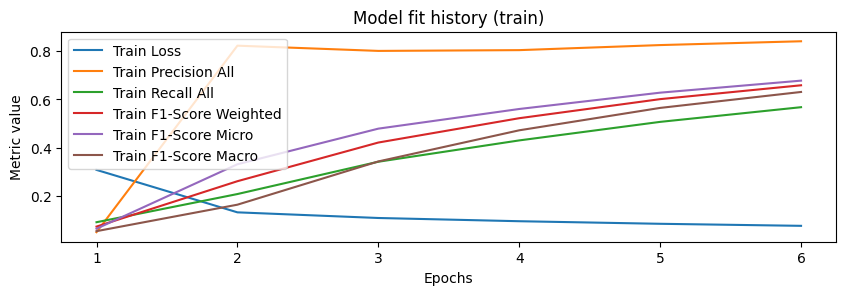

In [8]:
stats = history.history
train_stats = {
    'Train Loss': stats['loss'],
    'Train Precision All': stats['precision@0.5/all'],
    'Train Recall All': stats['recall@0.5/all'],
    'Train F1-Score Weighted': stats['f1_score@0.5/all'],
    'Train F1-Score Micro': stats['f1_score_micro@0.5/all'],
    'Train F1-Score Macro': stats['f1_score_macro@0.5/all'],
}

utils.plot_history(train_stats, title='Model fit history (train)')

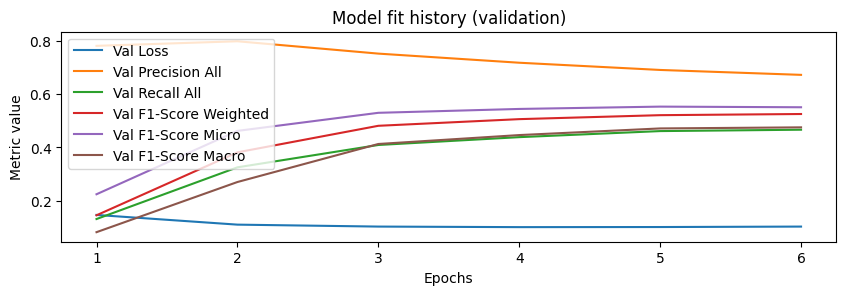

In [9]:
val_stats = {
    'Val Loss': stats['val_loss'],
    'Val Precision All': stats['val_precision@0.5/all'],
    'Val Recall All': stats['val_recall@0.5/all'],
    'Val F1-Score Weighted': stats['val_f1_score@0.5/all'],
    'Val F1-Score Micro': stats['val_f1_score_micro@0.5/all'],
    'Val F1-Score Macro': stats['val_f1_score_macro@0.5/all'],
}
utils.plot_history(val_stats, title='Model fit history (validation)')

## Score test and run most-important metrics on emotions prediction

In [10]:
from tensorflow.keras.metrics import Precision
from tensorflow_addons.metrics import F1Score


test_metrics = {
    'TP Rate (precision)': Precision(),
    'F1-Score (micro)': F1Score(num_classes=len(classes), threshold=THRESHOLD, average='micro'),
    'F1-Score (macro)': F1Score(num_classes=len(classes), threshold=THRESHOLD, average='macro'),
}
utils.score_test(test_ds, model, test_metrics.values(), THRESHOLD)
for name, metric in test_metrics.items():
    print('{}: {:.4f}'.format(name, metric.result().numpy()))

TP Rate (precision): 0.6415
F1-Score (micro): 0.5816
F1-Score (macro): 0.5167


## Score test and run most-important metrics on sentiments prediction

In [11]:
sentiments = utils.load_sentiments(DATASET_DIR)
sentiment_map = utils.map_sentiments(classes, sentiments)
del sentiment_map[27]
test_metrics = {
    'TP Rate (precision)': Precision(),
    'F1-Score (micro)': F1Score(num_classes=len(sentiments), threshold=THRESHOLD, average='micro'),
    'F1-Score (macro)': F1Score(num_classes=len(sentiments), threshold=THRESHOLD, average='macro'),
}
utils.score_test(test_ds, model, test_metrics.values(),
                           THRESHOLD, sentiment_map)
for name, metric in test_metrics.items():
    print('{}: {:.4f}'.format(name, metric.result().numpy()))

TP Rate (precision): 0.8593
F1-Score (micro): 0.7590
F1-Score (macro): 0.7160


In [12]:
utils.test_examples(model, classes)

I am feeling great today!: admiration 👏
The weather is so good: admiration 👏
I have performed well at the university: 
The war has started: 
He is desperate in this cruel world: 
I love the feeling when my girlfriend hugs me: love ❤️
I hate monday mornings: anger 😡
Merry Christmas! I told Santa you were good this year and asked him to bring you a year full of joy and pleasure : joy 😃
brilliant! Such a detailed review, it was a pleasure, thank you! Guys, make sure you find time to read :) Aaaaand you can actually choose sth new): admiration 👏 gratitude 🙏
I have the new pan for pancakes.: 
Relax, bro. Take it easy: approval 👍 relief 😅
WTF? Are they kidding us? I'm gonna argue with the manager!: 
OMG, yep!!! That is the final answer! Thank you so much!: gratitude 🙏
I am so glad this is over: joy 😃
Sorry, I feel bad for having said that: remorse 😔 sadness 😞
Happy birthday, my friend! I wish you a lot of success!: 
What a shame! I will never talk to him: embarrassment 😳
What if she knows? W

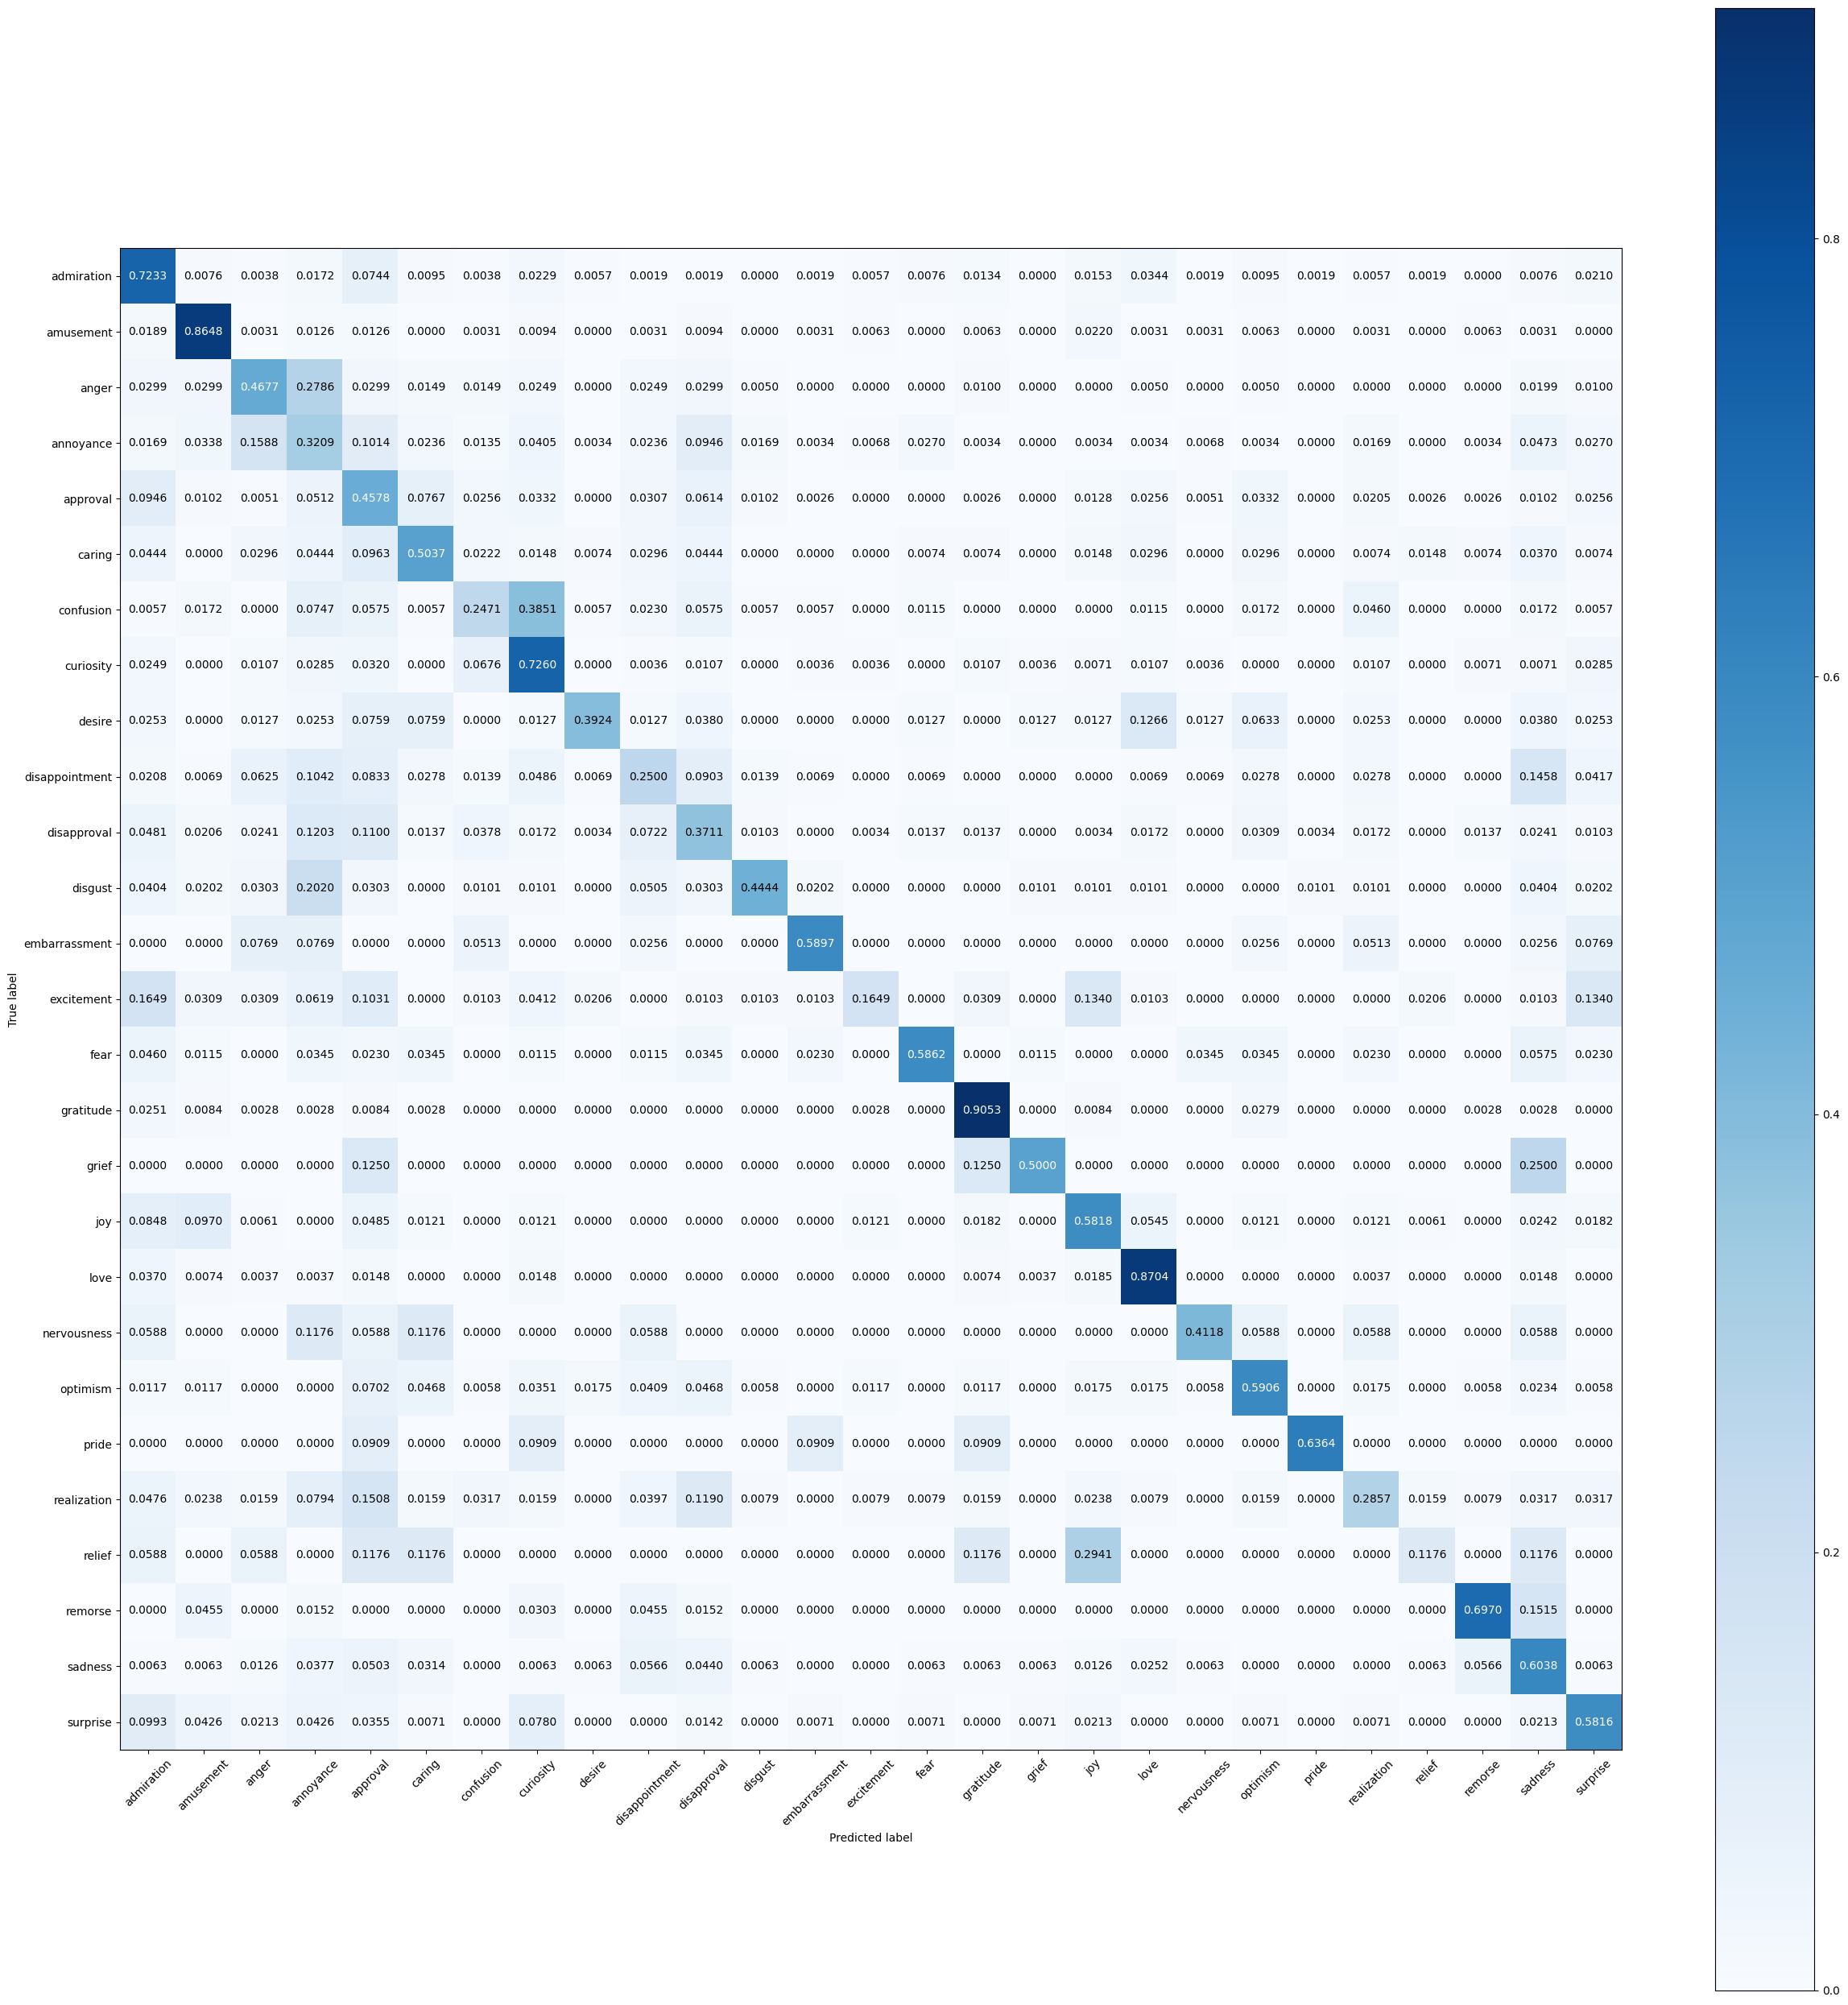

In [13]:
utils.plot_conf_mtrx_all(model, test_ds, classes, True)

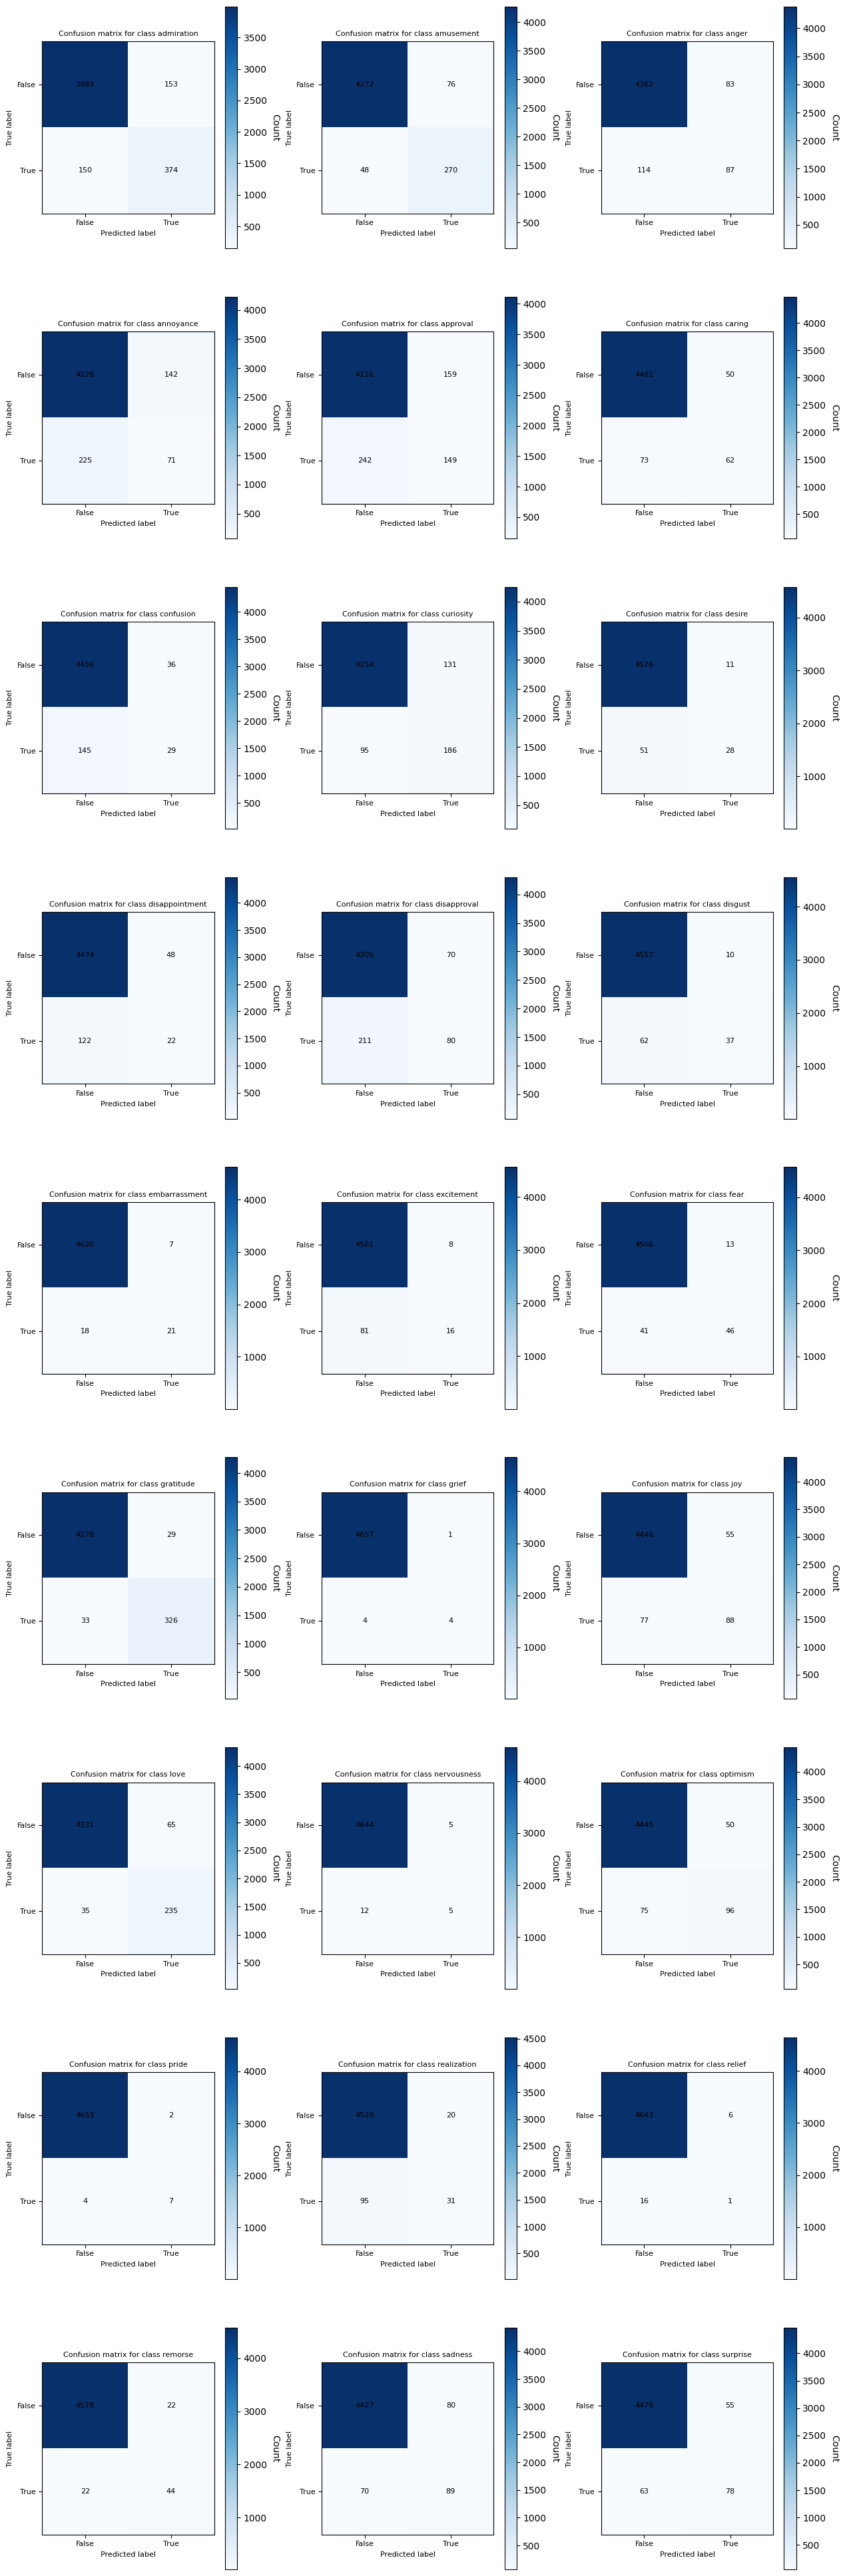

In [14]:
utils.plot_conf_mtrx_per_class(model, test_ds, classes)

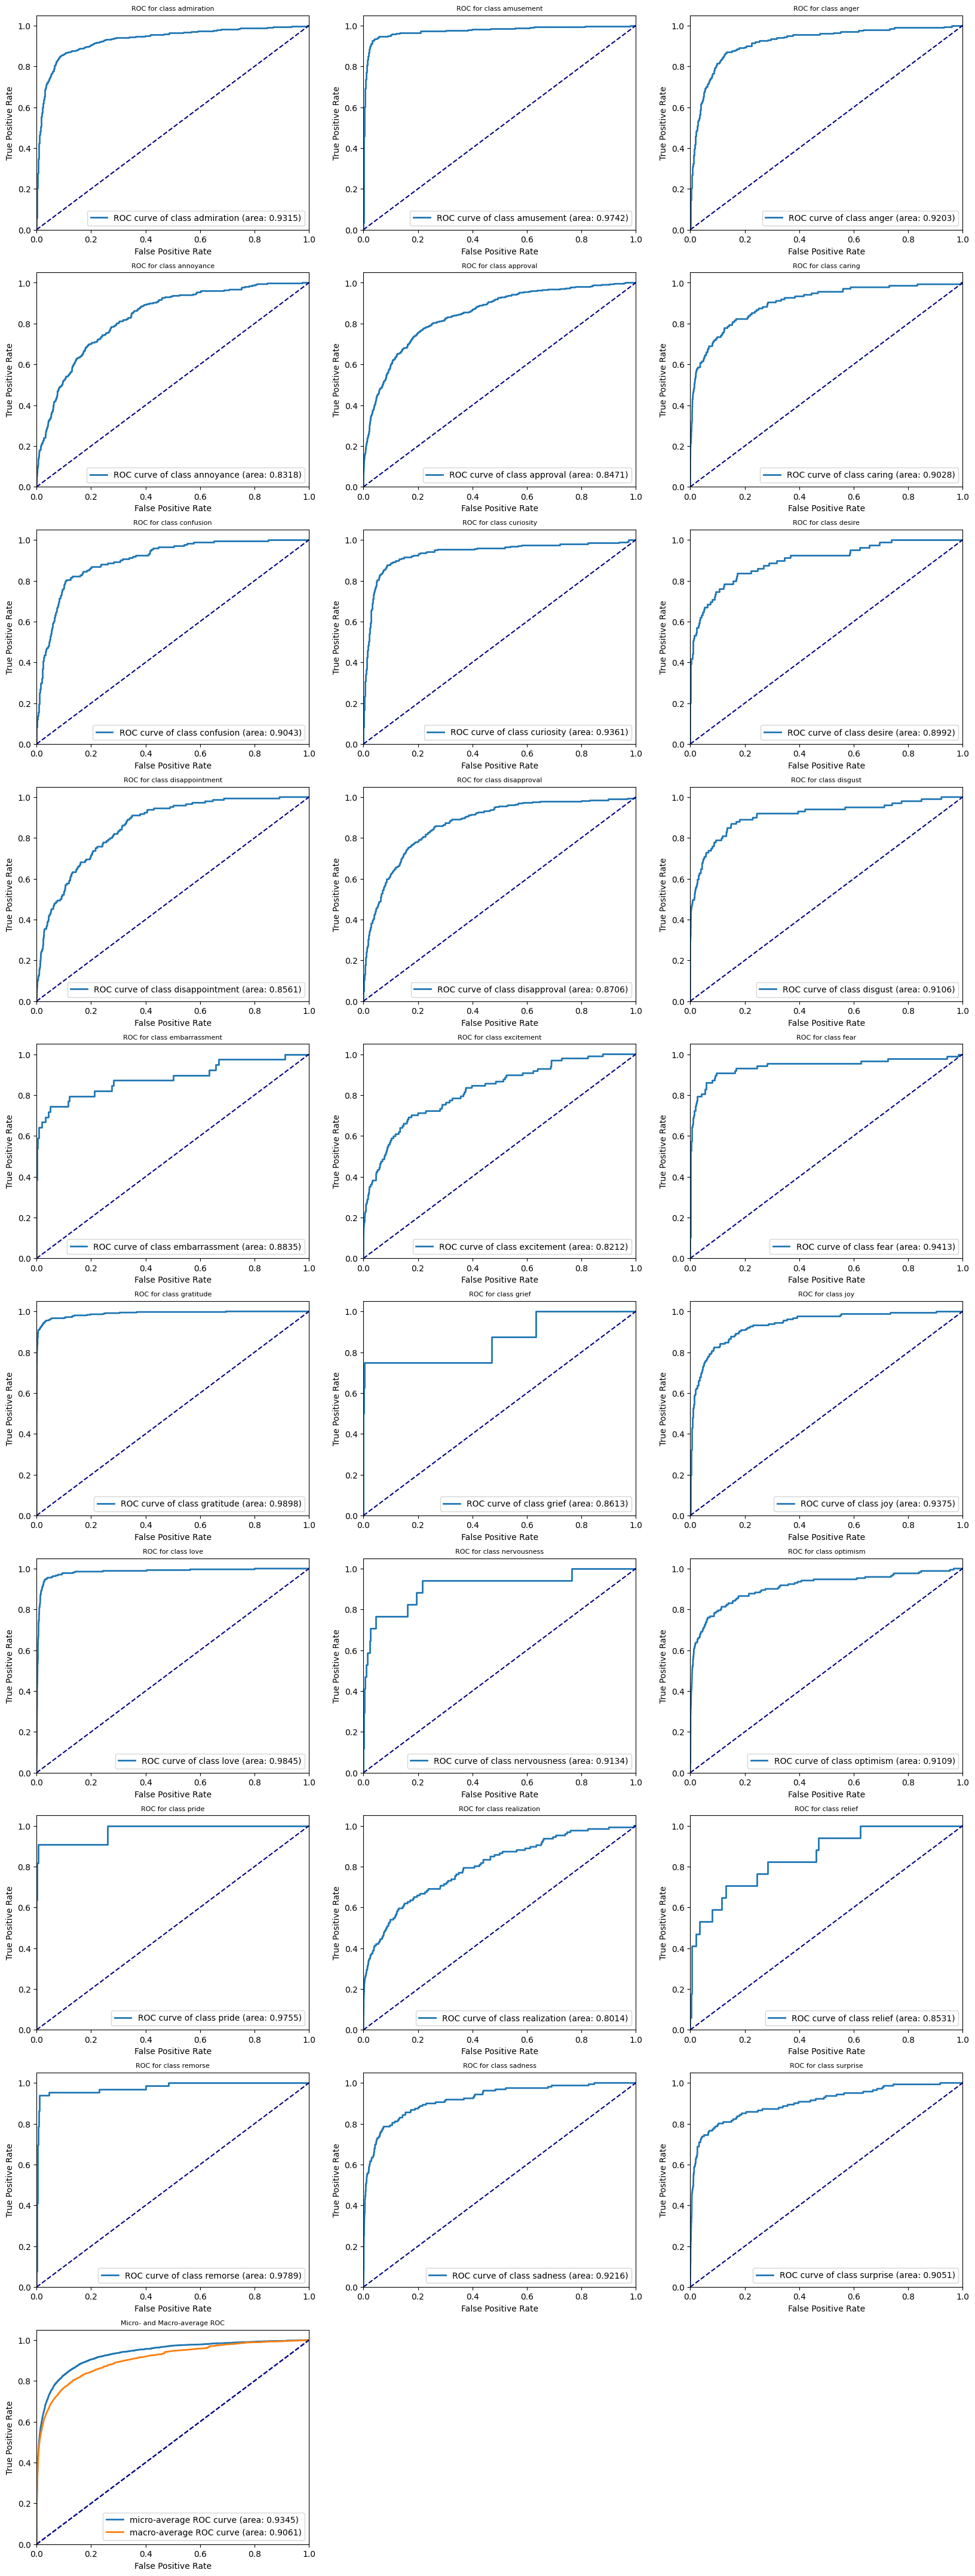

In [15]:
utils.plot_roc_curves(test_ds, model, classes)

In [16]:
model.save_weights('./models/bert_0_7_3')